In [0]:
import os
import math
import pandas as pd
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [0]:
cd "/content/Drive/My Drive/Spring 2019/ML/sample for project"

/content/Drive/My Drive/Spring 2019/ML/sample for project


In [0]:
integrated_df =pd.read_csv('vector_form.csv')

In [0]:
integrated_df.shape

(11429, 13763)

In [0]:
#integrated_df.shape, text_df.shape

((11429, 13763), (11429, 13669))

In [0]:
cb_num = 0
for i in range(len(integrated_df)):
  if integrated_df['truthClassInt'][i] == 1:
    cb_num+=1
cb_num

2595

In [0]:
#image representation clipping
image_col = ['person_y', 'bicycle', 'car_y', 'motorcycle', 'airplane', 'bus', 'train_y', 'truck_y', 'boat_y',
 'traffic light', 'fire hydrant',  'stop sign', 'parking meter', 'bench_y', 'bird_y', 'cat_y', 'dog_y', 'horse',
 'sheep_y', 'cow_y', 'elephant', 'bear_y', 'zebra_y', 'giraffe', 'backpack_y', 'umbrella_y', 'handbag_y', 'tie_y',
 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard_y',
 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup_y', 'fork_y', 'knife_y', 'spoon', 'bowl_y', 'banana_y', 'apple',
 'sandwich_y', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza_y', 'donut_y', 'cake_y', 'chair_y', 'couch', 'potted plant',
 'bed_y', 'dining table', 'toilet_y', 'tv_y', 'laptop_y', 'mouse', 'remote', 'keyboard_y', 'cell phone', 'microwave', 'oven_y',
 'toaster_y', 'sink_y', 'refrigerator', 'book_y', 'clock_y', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [0]:
# normalizing the image representation
# clipping to 2 instead of 1 to reserve the multiple objects in image

for col_name in image_col:
  for i in range(len(integrated_df)):
    if integrated_df[col_name][i] >2:
      integrated_df.set_value(i, col_name, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [0]:
col= ['id_y', 'postMedia', 'postText', 'postTimestamp', 'targetCaptions', 'targetDescription',	'targetKeywords',	'targetParagraphs',	'targetTitle',	'truthClass',	'truthJudgments',	'truthMean',	'truthMedian',	'truthMode', 'truthClassInt']

In [0]:
truth = pd.DataFrame(integrated_df['truthClassInt'])

In [0]:
integrated_df = integrated_df.drop(col,axis =1)

In [0]:
#text_df = text_df.drop('truthClassInt',axis = 1)

In [0]:
import numpy as np
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [0]:
integrated_df, X_test, truth, Y_test = train_test_split(integrated_df, truth, test_size = 0.2)

In [0]:
#create data frame only with text which will be used for comparision baseline
text_df = integrated_df.drop(image_col, axis = 1)

In [0]:
X_test_t = X_test.drop(image_col, axis = 1)

In [0]:
integrated_df.shape, text_df.shape, X_test.shape, X_test_t.shape, truth.shape, Y_test.shape

((9143, 13748),
 (9143, 13668),
 (2286, 13748),
 (2286, 13668),
 (9143, 1),
 (2286, 1))

In [0]:
#make data frames into numpy arrays
inte_df_array = np.array(integrated_df)
text_df_array = np.array(text_df)
X_test_array = np.array(X_test)
X_test_t_array = np.array(X_test_t)
truth_array= np.array(truth)
Y_test_array = np.array(Y_test)

In [0]:
def cv_training(clf_list, X, Y, x_test, y_test):
  results = []
  names = []
  res_list = []
  scoring_method = 'accuracy'
  for name, model in clf_list:
    print('classifier:', name)
    kfold = KFold(n_splits=10, random_state = 5)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring_method)
    results.append(cv_results)
    names.append(name)
    print('1. Cross Validation Info')
    msg = "%s: mean= %f, std = %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    #test on test data
    print("Testing")
    model.fit(X,Y)
    y_pred = model.predict(x_test)
    test_result = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix :')
    print(test_result)
    res = accuracy_score(y_test, y_pred)
    res_list.append(res)
    print('Accuracy Score:', res)
    print('Report:')
    print (classification_report(y_test,y_pred))
    print('AUC Score: ',metrics.roc_auc_score(y_test, y_pred))
   
  #boxplot algorithm comparision
  fig = plt.figure()
  fig.suptitle('Model Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(names)
  plt.show()
  
  return res_list
  

plotting two things:

(1) box plot for cross validation training for both datasets

(2) accuracy comparision based on model

In [0]:
clf_list = []
clf_list.append(('CART', DecisionTreeClassifier()))
clf_list.append(('NB', MultinomialNB()))
clf_list.append(('LR', LogisticRegression()))
#clf_list.append(('KNN', KNeighborsClassifier()))
clf_list.append(('GB', GradientBoostingClassifier()))
clf_list.append(('RF', RandomForestClassifier()))

classifier: CART
1. Cross Validation Info
CART: mean= 0.762877, std = 0.009173
Testing
Confusion Matrix :
[[1541  231]
 [ 288  226]]
Accuracy Score: 0.7729658792650919
Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1772
           1       0.49      0.44      0.47       514

   micro avg       0.77      0.77      0.77      2286
   macro avg       0.67      0.65      0.66      2286
weighted avg       0.76      0.77      0.77      2286

AUC Score:  0.6546637710692045
classifier: NB


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

1. Cross Validation Info
NB: mean= 0.790221, std = 0.008587
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
[[1547  225]
 [ 242  272]]
Accuracy Score: 0.7957130358705162
Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1772
           1       0.55      0.53      0.54       514

   micro avg       0.80      0.80      0.80      2286
   macro avg       0.71      0.70      0.70      2286
weighted avg       0.79      0.80      0.79      2286

AUC Score:  0.7011038550386031
classifier: LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:43

1. Cross Validation Info
LR: mean= 0.815158, std = 0.008666
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
[[1632  140]
 [ 263  251]]
Accuracy Score: 0.8237095363079615
Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1772
           1       0.64      0.49      0.55       514

   micro avg       0.82      0.82      0.82      2286
   macro avg       0.75      0.70      0.72      2286
weighted avg       0.81      0.82      0.81      2286

AUC Score:  0.704660038119999
classifier: GB


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

1. Cross Validation Info
GB: mean= 0.805424, std = 0.005093
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
[[1718   54]
 [ 379  135]]
Accuracy Score: 0.810586176727909
Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1772
           1       0.71      0.26      0.38       514

   micro avg       0.81      0.81      0.81      2286
   macro avg       0.77      0.62      0.64      2286
weighted avg       0.80      0.81      0.77      2286

AUC Score:  0.6160859368824164
classifier: RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_trai

1. Cross Validation Info
RF: mean= 0.799737, std = 0.006233
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Confusion Matrix :
[[1686   86]
 [ 356  158]]
Accuracy Score: 0.8066491688538933
Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1772
           1       0.65      0.31      0.42       514

   micro avg       0.81      0.81      0.81      2286
   macro avg       0.74      0.63      0.65      2286
weighted avg       0.79      0.81      0.78      2286

AUC Score:  0.6294301323659871


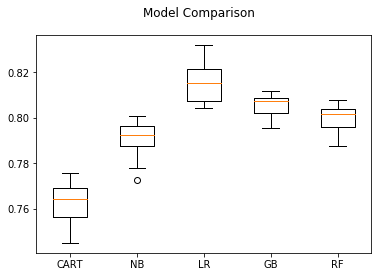

In [0]:
baseline_result = cv_training(clf_list, text_df_array, truth_array, X_test_t_array, Y_test_array)

In [0]:
baseline_result

[0.7729658792650919,
 0.7957130358705162,
 0.8237095363079615,
 0.810586176727909,
 0.8066491688538933]

classifier: CART
1. Cross Validation Info
CART: mean= 0.764080, std = 0.009495
Testing
Confusion Matrix :
[[1537  235]
 [ 295  219]]
Accuracy Score: 0.7681539807524059
Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1772
           1       0.48      0.43      0.45       514

   micro avg       0.77      0.77      0.77      2286
   macro avg       0.66      0.65      0.65      2286
weighted avg       0.76      0.77      0.76      2286

AUC Score:  0.6467257643762462
classifier: NB


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

1. Cross Validation Info
NB: mean= 0.791534, std = 0.007436
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
[[1553  219]
 [ 251  263]]
Accuracy Score: 0.7944006999125109
Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1772
           1       0.55      0.51      0.53       514

   micro avg       0.79      0.79      0.79      2286
   macro avg       0.70      0.69      0.70      2286
weighted avg       0.79      0.79      0.79      2286

AUC Score:  0.6940419934827098
classifier: LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:43

1. Cross Validation Info
LR: mean= 0.811877, std = 0.009369
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
[[1641  131]
 [ 267  247]]
Accuracy Score: 0.8258967629046369
Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1772
           1       0.65      0.48      0.55       514

   micro avg       0.83      0.83      0.83      2286
   macro avg       0.76      0.70      0.72      2286
weighted avg       0.81      0.83      0.82      2286

AUC Score:  0.7033084909223459
classifier: GB


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

1. Cross Validation Info
GB: mean= 0.807064, std = 0.007154
Testing


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
[[1721   51]
 [ 378  136]]
Accuracy Score: 0.8123359580052494
Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1772
           1       0.73      0.26      0.39       514

   micro avg       0.81      0.81      0.81      2286
   macro avg       0.77      0.62      0.64      2286
weighted avg       0.80      0.81      0.78      2286

AUC Score:  0.617905200656999
classifier: RF


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

1. Cross Validation Info
RF: mean= 0.797987, std = 0.007687
Testing


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Confusion Matrix :
[[1694   78]
 [ 367  147]]
Accuracy Score: 0.805336832895888
Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1772
           1       0.65      0.29      0.40       514

   micro avg       0.81      0.81      0.81      2286
   macro avg       0.74      0.62      0.64      2286
weighted avg       0.78      0.81      0.77      2286

AUC Score:  0.6209870796040439


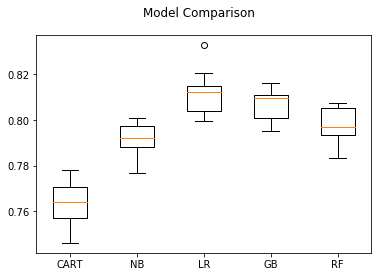

In [0]:
txt_img_result = cv_training(clf_list, inte_df_array, truth_array, X_test_array, Y_test_array)

In [0]:
txt_img_result

[0.7681539807524059,
 0.7944006999125109,
 0.8258967629046369,
 0.8123359580052494,
 0.805336832895888]

In [0]:
inte_df_array.shape, text_df_array.shape

((9143, 13748), (9143, 13668))

CNN Test


In [0]:
def CNN_model(X, Y, X_test, Y_test):
  
  # extract the valid sets
  sss = StratifiedShuffleSplit(test_size=0.1, random_state=10)
  for train_index, valid_index in sss.split(X, Y):
      X_train, X_valid = X[train_index], X[valid_index]
      y_train, y_valid = Y[train_index], Y[valid_index]
  
  print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
  
  nrows, ncols = X_train.shape
  valid_rows = len(X_valid)
  
  # reshape the array
  X_train = X_train.reshape(nrows, ncols, 1)
  X_valid = X_valid.reshape(valid_rows, ncols, 1)
  y_train = np_utils.to_categorical(y_train, 2)
  y_valid = np_utils.to_categorical(y_valid, 2)
  
  nrows_t, nrows_c = X_test.shape
  X_test = X_test.reshape(nrows_t, nrows_c, 1)
  #Y_test = np_utils.to_categorical(Y_test, 2)
  
  # convolutional neural network model
  
  model = Sequential()
  model.add(Convolution1D(filters=100, kernel_size=10, activation='relu', input_shape = (ncols, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(3))
  model.add(Convolution1D(filters=100, kernel_size=10, activation='relu'))
  #model.add(BatchNormalization())
  model.add(MaxPooling1D(3))
  model.add(Flatten())
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  print(model.summary)
  
  sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
  model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  
  nb_epoch = 30
  model.fit(X_train, y_train, epochs=nb_epoch, validation_data=(X_valid, y_valid), batch_size=120)
  

  return model
  

In [0]:
baseline_cnn = CNN_model(text_df_array, truth_array, X_test_t_array, Y_test_array)

(8228, 13668) (8228, 1) (915, 13668) (915, 1)
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7fb890a3ba90>>
Train on 8228 samples, validate on 915 samples
Epoch 1/30
8228/8228 [==============================] - 24s 3ms/step - loss: 0.4549 - acc: 0.7940 - val_loss: 0.4604 - val_acc: 0.7923
Epoch 2/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3837 - acc: 0.8317 - val_loss: 0.5967 - val_acc: 0.7825
Epoch 3/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3529 - acc: 0.8439 - val_loss: 0.9123 - val_acc: 0.7738
Epoch 4/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3287 - acc: 0.8557 - val_loss: 0.8530 - val_acc: 0.7738
Epoch 5/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3032 - acc: 0.8659 - val_loss: 0.7083 - val_acc: 0.7781
Epoch 6/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.2810 - acc: 0.8813 - val_loss: 1.2652 - val_acc: 0.7727
E

In [0]:
inte_model = CNN_model(inte_df_array, truth_array, X_test_array, Y_test_array)

(8228, 13748) (8228, 1) (915, 13748) (915, 1)
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7fb890a3bf98>>
Train on 8228 samples, validate on 915 samples
Epoch 1/30
8228/8228 [==============================] - 26s 3ms/step - loss: 0.5002 - acc: 0.7888 - val_loss: 0.6253 - val_acc: 0.7770
Epoch 2/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3924 - acc: 0.8269 - val_loss: 0.7841 - val_acc: 0.7727
Epoch 3/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3635 - acc: 0.8393 - val_loss: 0.7181 - val_acc: 0.7727
Epoch 4/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3347 - acc: 0.8555 - val_loss: 0.6874 - val_acc: 0.7803
Epoch 5/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.3095 - acc: 0.8676 - val_loss: 0.7866 - val_acc: 0.7749
Epoch 6/30
8228/8228 [==============================] - 23s 3ms/step - loss: 0.2907 - acc: 0.8741 - val_loss: 0.7055 - val_acc: 0.7858
E

In [0]:
X_test_array.shape, Y_test_array.shape

((2286, 13748, 1), (2286, 2))

In [0]:
X_test_t_array.shape, Y_test_array.shape

((2286, 13668, 1), (2286, 2))

In [0]:
X_test_t_array = X_test_t_array.reshape(len(X_test_t_array), 13668, 1)

In [0]:
y_pred = baseline_cnn.predict(X_test_t_array)

In [0]:
for i in range (len(y_pred)):
  if y_pred[i][0] < y_pred[i][1]:
    y_pred[i][0], y_pred[i][1] = 0, 1
  else:
    y_pred[i][0], y_pred[i][1] = 1, 0

In [0]:
accuracy_score(Y_test_array, y_pred)

0.7817147856517935

In [0]:
X_test_array = X_test_array.reshape(len(X_test_array), 13748, 1)

In [0]:
y_pred2 = inte_model.predict(X_test_array)

In [0]:
for i in range (len(y_pred2)):
  if y_pred[i][0] < y_pred2[i][1]:
    y_pred2[i][0], y_pred2[i][1] = 0, 1
  else:
    y_pred2[i][0], y_pred2[i][1] = 1, 0

In [0]:
accuracy_score(Y_test_array, y_pred2)

0.7817147856517935